# 2D CNN using PyTorch for image classification

### create  "signature":
#### Run the cell but do NOT modify the cell
#### The signature needs to be displayed right below the cell in this file

In [2]:
import platform, socket, getpass
from time import time
from datetime import datetime
import random
signature_for_cnn=[socket.gethostbyname(socket.gethostname()),
                   getpass.getuser(),
                   datetime.now(),
                   random.random()]
print(signature_for_cnn)

['172.28.0.12', 'root', datetime.datetime(2025, 5, 9, 2, 33, 23, 409654), 0.8741508163356482]


In [3]:
#sample code to save model and signature
#torch.save({"model":model.state_dict(),
#            "signature":signature_for_cnn},
#            "CNN_best.pt")

### This is a complete application of image classification using a 2D CNN
steps: \
define a 2D CNN \
define a function for training the CNN \
define a function for testing the CNN \
define a function for saving the model and your `signature_for_cnn` \
load data \
train the CNN in a for loop using the training set and the validation set\
evalaute the best model on the test set\
display accuracy and confusion matrix for each of the three sets: train, validation, and test sets
### you may use the code in lecture nodes
### write your code below this line

Signature: ['172.28.0.12', 'root', '2025-05-09T02:33:57.207069', 0.8532985159267206]
Epoch 01 | Train Loss: 1.8496 | Val Acc: 59.00%
Epoch 02 | Train Loss: 0.9536 | Val Acc: 68.20%
Epoch 03 | Train Loss: 0.7597 | Val Acc: 72.40%
Epoch 04 | Train Loss: 0.6779 | Val Acc: 73.30%
Epoch 05 | Train Loss: 0.6085 | Val Acc: 74.10%
Epoch 06 | Train Loss: 0.5329 | Val Acc: 77.10%
Epoch 07 | Train Loss: 0.5101 | Val Acc: 77.70%
Epoch 08 | Train Loss: 0.4879 | Val Acc: 80.10%
Epoch 09 | Train Loss: 0.4182 | Val Acc: 79.90%
Epoch 10 | Train Loss: 0.4182 | Val Acc: 78.90%
Epoch 11 | Train Loss: 0.4092 | Val Acc: 78.40%
Epoch 12 | Train Loss: 0.3834 | Val Acc: 80.60%
Epoch 13 | Train Loss: 0.3421 | Val Acc: 80.80%
Epoch 14 | Train Loss: 0.3128 | Val Acc: 81.70%
Epoch 15 | Train Loss: 0.3054 | Val Acc: 80.70%
Epoch 16 | Train Loss: 0.2909 | Val Acc: 80.60%
Epoch 17 | Train Loss: 0.2792 | Val Acc: 82.30%
Epoch 18 | Train Loss: 0.2613 | Val Acc: 81.60%
Epoch 19 | Train Loss: 0.2360 | Val Acc: 81.90%
Epo

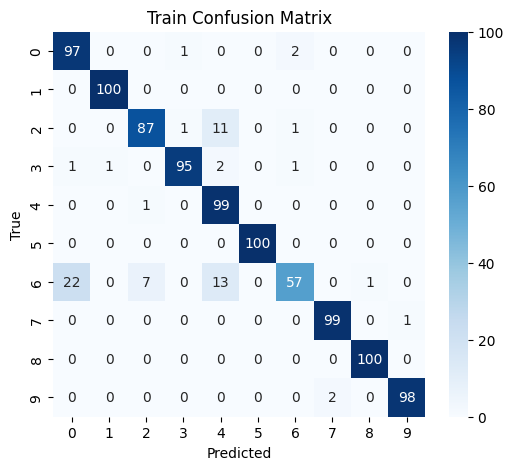

Validation Accuracy: 83.10%


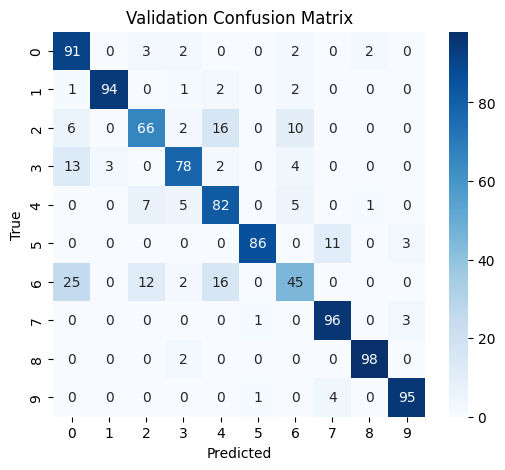

Test Accuracy: 80.50%


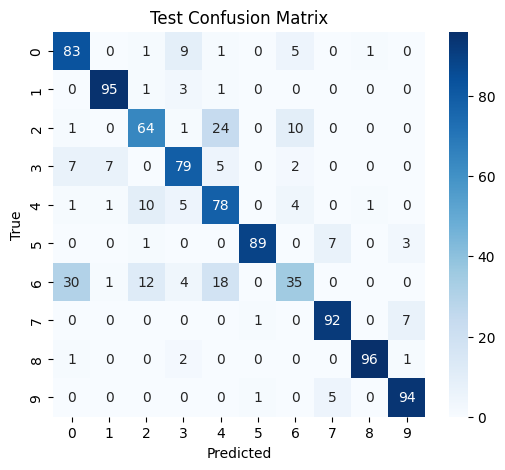

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import socket, getpass
from datetime import datetime
import random

# ----------------------------
# 1) Load & reshape dataset
# ----------------------------
data = torch.load("/content/sample_data/H5T0_train_val_test_data.pt", weights_only=False)
X_train = torch.tensor(data['X_train']).float().view(-1, 1, 28, 28)
y_train = torch.tensor(data['Y_train']).long()
X_val   = torch.tensor(data['X_val']).float().view(-1, 1, 28, 28)
y_val   = torch.tensor(data['Y_val']).long()
X_test  = torch.tensor(data['X_test']).float().view(-1, 1, 28, 28)
y_test  = torch.tensor(data['Y_test']).long()

batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val, y_val),     batch_size=batch_size)
test_loader  = DataLoader(TensorDataset(X_test, y_test),   batch_size=batch_size)

# ----------------------------
# 2) Define a 2D CNN
# ----------------------------
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # two conv layers + pooling
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        # fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # [B,32,28,28]
        x = self.pool(x)           # [B,32,14,14]
        x = F.relu(self.conv2(x))  # [B,64,14,14]
        x = self.pool(x)           # [B,64,7,7]
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ----------------------------
# 3) Training function
# ----------------------------
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(Xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)
    return total_loss / len(loader.dataset)

# ----------------------------
# 4) Evaluation function
# ----------------------------
def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    preds, targets = [], []
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            out = model(Xb)
            _, p = out.max(1)
            total += yb.size(0)
            correct += (p == yb).sum().item()
            preds.extend(p.cpu().tolist())
            targets.extend(yb.cpu().tolist())
    acc = 100 * correct / total
    return acc, preds, targets

# ----------------------------
# 5) Save model + signature
# ----------------------------
def save_model(path, model_state, signature):
    torch.save({
        'model_state': model_state,
        'signature': signature
    }, path)

# ----------------------------
# 6) Setup
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

signature_for_cnn = [
    socket.gethostbyname(socket.gethostname()),
    getpass.getuser(),
    datetime.now().isoformat(),
    random.random()
]
print("Signature:", signature_for_cnn)

# ----------------------------
# 7) Training loop with validation
# ----------------------------
best_val_acc = 0.0
best_model_state = None

for epoch in range(1, 21):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_acc, _, _ = evaluate(model, val_loader, device)
    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.2f}%")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()

# ----------------------------
# 8) Save the best model
# ----------------------------
save_model("CNN_best.pt", best_model_state, signature_for_cnn)

# ----------------------------
# 9) Load & evaluate best model
# ----------------------------
model.load_state_dict(best_model_state)

for name, loader in zip(["Train", "Validation", "Test"],
                        [train_loader, val_loader, test_loader]):
    acc, preds, targets = evaluate(model, loader, device)
    print(f"{name} Accuracy: {acc:.2f}%")
    cm = confusion_matrix(targets, preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()